### Load the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the datasets, ignoring the first column
train_data = pd.read_csv('train.csv',
                         usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary
test_data = pd.read_csv('test.csv',
                        usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary

X_train = train_data[['x', 'y']].values
y_train = train_data['cls'].values

X_test = test_data[['x', 'y']].values
y_test = test_data['cls'].values

### Visualize the Data

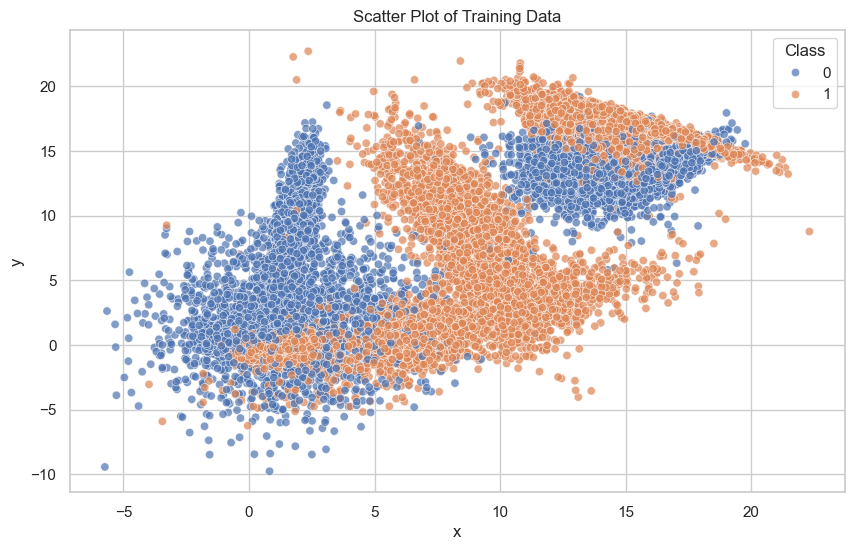

In [3]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='x', y='y', hue='cls', palette='deep', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Class')
plt.show()


### Analyze the Data

In [4]:
# Check the distribution of classes
class_distribution = train_data['cls'].value_counts()
print(class_distribution)

# Summary statistics of the features
print(train_data.describe())


cls
1    12016
0    11984
Name: count, dtype: int64
                  x             y           cls
count  24000.000000  24000.000000  24000.000000
mean       6.897980      6.840433      0.500667
std        6.638242      6.826364      0.500010
min       -5.739819     -9.763944      0.000000
25%        0.887007      0.421379      0.000000
50%        4.531249      4.941289      1.000000
75%       13.588332     13.693109      1.000000
max       22.312527     22.722494      1.000000


# evaluate model

In [5]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(X_train)

    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')

    print("Training Metrics:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print()

    # Predict on testing data
    y_test_pred = model.predict(X_test)

    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')

    print("Testing Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")


# hyper parameter tuning

In [6]:
def tune_hyperparameters(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    print("Starting hyperparameter tuning...")

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=4, verbose=1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("\nHyperparameter Tuning Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")

    return best_model


### phase1: Bagging

In [7]:
class Bagging:
    def __init__(self, base_model=None, n_estimators=10, random_state=None):
        """
        Custom implementation of the Bagging algorithm.

        Parameters:
        - base_model: The base model (e.g., DecisionTreeClassifier).
        - n_estimators: Number of estimators (default: 10).
        - random_state: Random seed for reproducibility (default: None).
        """
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.bootstrap_samples = []

        # Seed for reproducibility
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """
        Fits the Bagging ensemble to the data.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).
        - y: Target vector (numpy array or pandas Series).
        """
        self.models = []  # Reset models
        self.bootstrap_samples = []  # Reset bootstrap samples

        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            self.bootstrap_samples.append(indices)

            # Train a new base model
            model = self.base_model()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        """
        Predicts the output for the given feature matrix using majority voting.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).

        Returns:
        - Predictions (numpy array).
        """
        # Collect predictions from all models
        predictions = np.array([model.predict(X) for model in self.models])
        # Perform majority voting
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return final_predictions


In [8]:
# Train Bagging ensemble
custom_bagging = tune_hyperparameters(Bagging(), {'n_estimators': [10, 20, 30, 40], 'random_state': [42],
                                                  'base_model': [DecisionTreeClassifier]}, X_train, y_train)

# Train 5 individual Decision Trees
trees = []
for i in range(5):
    tree = DecisionTreeClassifier(random_state=42 + i)
    tree.fit(X_train, y_train)
    trees.append(tree)


# Define a function to plot decision boundaries
def plot_decision_boundary(model, X, y, title, ax):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
    ax.set_title(title)


# Plot decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

# Plot each Decision Tree
for i, tree in enumerate(trees):
    plot_decision_boundary(tree, X_test, y_test, f"Tree {i + 1}", axes[i])

# Plot Bagging model
plot_decision_boundary(custom_bagging, X_test, y_test, "Bagging", axes[-1])

plt.tight_layout()
plt.show()


Starting hyperparameter tuning...


TypeError: Cannot clone object '<__main__.Bagging object at 0x00000267704B4BF0>' (type <class '__main__.Bagging'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [13]:
# Train Bagging ensemble using sklearn's BaggingClassifier
sklearn_bagging = tune_hyperparameters(BaggingClassifier(), {
    'n_estimators': [10, 20, 30, 40],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Proportion of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 1.0],  # Proportion of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether samples are drawn with replacement
    'estimator': [DecisionTreeClassifier()]  # The base estimator to fit on random subsets of the dataset
},X_train, y_train)
sklearn_bagging.fit(X_train, y_train)

# evaluate_model(custom_bagging, X_train, y_train, X_test, y_test)
evaluate_model(sklearn_bagging, X_train, y_train, X_test, y_test)


Starting hyperparameter tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Hyperparameter Tuning Complete!
Best Parameters: {'bootstrap': True, 'estimator': DecisionTreeClassifier(), 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 30}
Best Cross-Validation Score: 0.8667
Training Metrics:
Accuracy: 0.9560
F1 Score: 0.9560
Precision: 0.9560
Recall: 0.9560

Testing Metrics:
Accuracy: 0.8582
F1 Score: 0.8582
Precision: 0.8583
Recall: 0.8582
